In [ ]:
!sudo apt update && sudo apt install ffmpeg

!pip install -q transformers gradio openai-whisper torch

import torch
import gradio as gr
import whisper
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import drive
import os

drive.mount('/content/drive')
save_path = '/content/drive/MyDrive/ColabNotebooks/SavedModel_CyberBullying'
base_model_name = "distilbert-base-multilingual-cased"

print("Loading saved classifier...")
try:
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    model = AutoModelForSequenceClassification.from_pretrained(save_path)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure you ran the training step (Step 2) and saved the model.")

print("Loading Whisper...")
whisper_model = whisper.load_model("base")

def classify_text_pipeline(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    results = {}
    for i, prob in enumerate(probabilities[0]):
        label_name = model.config.id2label[i]
        results[label_name] = float(prob)
    return results

def processing_hub(audio_path, text_input, text_file):
    print(f"\n--- NEW REQUEST ---")
    print(f"DEBUG INPUTS -> Audio: {audio_path}, Text: '{text_input}', File: {text_file}")

    recognized_text = ""
    source_info = ""

    if audio_path and isinstance(audio_path, str):
        source_info = "Source: Audio"
        print(f"Processing Audio file at: {audio_path}")
        try:
            result = whisper_model.transcribe(audio_path, language="en")
            recognized_text = result["text"]
            print(f"Recognized text: {recognized_text}")

            if not recognized_text.strip():
                return "Whisper heard silence. Try speaking louder or check microphone.", None

        except Exception as e:
            print(f"Audio Error: {e}")
            return f"Audio Error: {e}", None

    elif text_file is not None:
        source_info = "Source: File"
        print(f"Processing File: {text_file.name}")
        try:
            with open(text_file.name, 'r', encoding='utf-8') as f: recognized_text = f.read()
        except:
            with open(text_file.name, 'r', encoding='ISO-8859-1') as f: recognized_text = f.read()

    elif text_input and text_input.strip():
        source_info = "Source: Manual Input"
        print(f"Processing Text Input")
        recognized_text = text_input

    else:
        print("All inputs are empty!")
        return "No input data provided. \nHint: If using mic, make sure to press STOP recording before analyzing.", None

    if not recognized_text:
        return "Empty text after processing", None

    classification_result = classify_text_pipeline(recognized_text)

    return f"{source_info}\n\nRecognized Text: {recognized_text}", classification_result
with gr.Blocks(title="Cyber Bullying Detector", css="body {background-color: #f0f2f5}") as demo:
    gr.Markdown("Cyber Bullying Detector")
    gr.Markdown("Speak in English, upload a file, or type text to detect bullying.")

    with gr.Row():
        with gr.Column():
            with gr.Tab("Audio (English)"):
                audio_in = gr.Audio(sources=["microphone", "upload"], type="filepath")
            with gr.Tab("Text"):
                text_in = gr.Textbox(lines=3, placeholder="Type something here...")
            with gr.Tab("File"):
                file_in = gr.File(file_types=[".txt"])

            with gr.Row():
                btn_run = gr.Button("Analyze", variant="primary")
                btn_clear = gr.Button("Clear")

        with gr.Column():
            text_out = gr.Textbox(label="Recognized Text")
            label_out = gr.Label(label="Prediction Result")

    btn_run.click(fn=processing_hub, inputs=[audio_in, text_in, file_in], outputs=[text_out, label_out])

    def clear_all(): return None, "", None, "", None
    btn_clear.click(fn=clear_all, inputs=[], outputs=[audio_in, text_in, file_in, text_out, label_out])

print("Launching Interface...")
demo.launch(debug=True, share=True)

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://cli.github.com/packages stable InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,845 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,622 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:14 https://r2u.stat.illi

/tmp/ipython-input-253693025.py:88: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(title="Cyber Bullying Detector", css="body {background-color: #f0f2f5}") as demo:


Launching Interface...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d0f483175375b25f9f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



--- NEW REQUEST ---
DEBUG INPUTS -> Audio: /tmp/gradio/abe63612acbfcafaf9fb27a15b148e49627850302d98a092ddc1a856e346b6f4/audio.wav, Text: '', File: None
Processing Audio file at: /tmp/gradio/abe63612acbfcafaf9fb27a15b148e49627850302d98a092ddc1a856e346b6f4/audio.wav


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Recognized text:  Let's play volleyball dumbness.


In [ ]:
!pip install -q transformers datasets evaluate accelerate gradio openai-whisper scikit-learn seaborn matplotlib
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

import pandas as pd
import numpy as np
import torch
import whisper
import gradio as gr
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
from google.colab import drive

drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 53.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/MyDrive/ColabNotebooks/Dataset/Cyber_Bullying.csv'
save_path = '/content/drive/MyDrive/ColabNotebooks/SavedModel_CyberBullying'
MODEL_NAME = "distilbert-base-multilingual-cased"

try:
    print("Завантаження та обробка даних...")
    df = pd.read_csv(
        dataset_path,
        sep=';',
        encoding='ISO-8859-1',
        on_bad_lines='skip',
        engine='python'
    )

    df.columns = df.columns.str.strip()

    if 'Text' in df.columns: df = df.rename(columns={'Text': 'text'})
    if 'Label' in df.columns: df = df.rename(columns={'Label': 'label'})

    df = df[['text', 'label']]
    df = df.dropna()

    df = df[pd.to_numeric(df['label'], errors='coerce').notnull()]
    df['label'] = df['label'].astype(int)

    print(f"Загальна кількість рядків у файлі: {len(df)}")

    print("Балансування датасету (50,000 label 0 + 50,000 label 1)...")

    df_normal = df[df['label'] == 0]
    df_bullying = df[df['label'] == 1]

    def sample_data(data, n=50000):
        if len(data) > n:
            return data.sample(n, random_state=42)
        else:
            return data

    df_normal_sampled = sample_data(df_normal, 50000)
    df_bullying_sampled = sample_data(df_bullying, 50000)

    print(f"   -> Звичайне мовлення (label 0): {len(df_normal_sampled)} рядків")
    print(f"   -> Кібербулінг (label 1): {len(df_bullying_sampled)} рядків")

    df = pd.concat([df_normal_sampled, df_bullying_sampled])

    df = df.sample(frac=1, random_state=42).reset_index(drop=True)

    print(f"Підсумковий розмір датасету для навчання: {len(df)} рядків.")

except Exception as e:
    print(f"Помилка при підготовці даних: {e}")
    raise e

unique_labels = sorted(df['label'].unique())
id2label = {0: "Звичайне мовлення", 1: "Кібербулінг"}
label2id = {v: k for k, v in id2label.items()}

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

print("Токенізація...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(unique_labels),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./results_cyber",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
)

print("Починаємо навчання...")
trainer.train()

print(f"Збереження моделі у {save_path}...")
if not os.path.exists(save_path): os.makedirs(save_path)

model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print("Готово! Модель навчено та збережено.")

⏳ Завантаження та обробка даних...
📊 Загальна кількість рядків у файлі: 448873
⚖️ Балансування датасету (50,000 label 0 + 50,000 label 1)...
   -> Звичайне мовлення (label 0): 50000 рядків
   -> Кібербулінг (label 1): 50000 рядків
✅ Підсумковий розмір датасету для навчання: 100000 рядків.
⏳ Токенізація...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Починаємо навчання...


Epoch,Training Loss,Validation Loss
1,0.239500,0.241607
2,0.175800,0.241144


💾 Збереження моделі у /content/drive/MyDrive/ColabNotebooks/SavedModel_CyberBullying...
🎉 Готово! Модель навчено та збережено.


Оцінка моделі...



=== Classification Report ===
                   precision    recall  f1-score   support

Звичайне мовлення       0.93      0.90      0.91      9922
      Кібербулінг       0.90      0.94      0.92     10078

         accuracy                           0.92     20000
        macro avg       0.92      0.92      0.92     20000
     weighted avg       0.92      0.92      0.92     20000



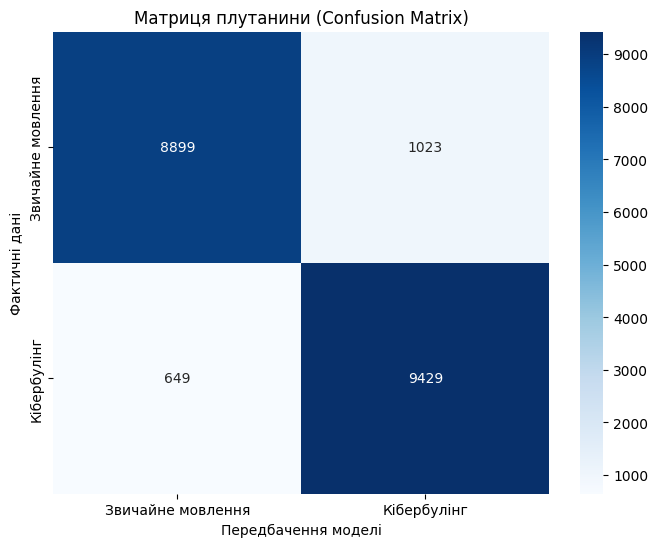

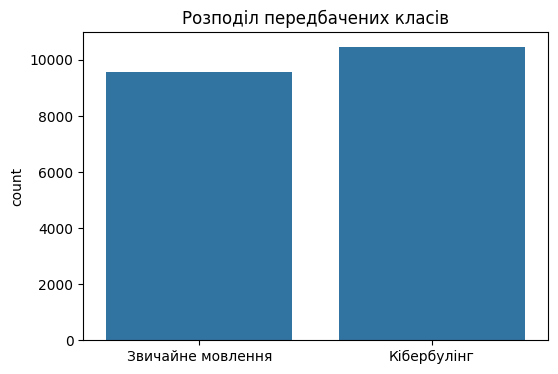

In [ ]:
print("Оцінка моделі...")
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
labels = test_df['label'].values

print("\n=== Classification Report ===")
print(classification_report(labels, preds, target_names=list(label2id.keys())))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(label2id.keys()),
            yticklabels=list(label2id.keys()))
plt.title('Матриця плутанини (Confusion Matrix)')
plt.ylabel('Фактичні дані')
plt.xlabel('Передбачення моделі')
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x=preds)
plt.title('Розподіл передбачених класів')
plt.xticks(ticks=[0, 1], labels=list(label2id.keys()))
plt.show()

In [ ]:
print("Завантаження Whisper (speech-to-text)...")
whisper_model = whisper.load_model("base")

def classify_text_pipeline(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(model.device)
    with torch.no_grad():
        logits = model(**inputs).logits
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    results = {}
    for i, prob in enumerate(probabilities[0]):
        label_name = model.config.id2label[i]
        results[label_name] = float(prob)
    return results

def processing_hub(audio_path, text_input, text_file):

    print(f"\n--- НОВИЙ ЗАПИТ ---")
    print(f"Audio Path: {audio_path}")
    print(f"Text Input: {text_input}")

    recognized_text = ""
    source_info = ""

    if audio_path and isinstance(audio_path, str):
        source_info = "Джерело: Аудіо файл/мікрофон"
        print("Обробка аудіо...")
        try:
            whisper_result = whisper_model.transcribe(audio_path)
            recognized_text = whisper_result["text"]
        except Exception as e:
            return f"Помилка обробки аудіо: {e}", None

    elif text_file is not None:
        source_info = "Джерело: Завантажений текстовий файл"
        print("Обробка файлу...")
        with open(text_file.name, 'r', encoding='utf-8') as f:
            recognized_text = f.read()

    elif text_input and len(text_input.strip()) > 0:
        source_info = "Джерело: Ручне введення"
        print("Обробка тексту...")
        recognized_text = text_input

    else:
        print("Помилка: Немає вхідних даних")
        return "Немає даних (переконайтесь, що аудіо завантажилось)", None

    classification_result = classify_text_pipeline(recognized_text)

    return f"{source_info}\n\nТекст: {recognized_text}", classification_result

custom_css = "body {background-color: #f4f4f9;}"

with gr.Blocks(css=custom_css, title="Детектор булінгу") as demo:
    gr.Markdown("# Система виявлення образливого мовлення (Audio & Text)")
    gr.Markdown("Завантажте аудіо, використайте мікрофон або введіть текст.")

    with gr.Row():
        with gr.Column():
            gr.Markdown("### 1. Вхідні дані")

            with gr.Tab("Аудіо"):
                audio_in = gr.Audio(sources=["microphone", "upload"], type="filepath", label="Запис")

            with gr.Tab("Текст"):
                text_in = gr.Textbox(lines=4, placeholder="Введіть текст...", label="Введення тексту")

            with gr.Tab("Файл"):
                file_in = gr.File(file_types=[".txt"], label="Текстовий файл")

            with gr.Row():
                submit_btn = gr.Button("Аналізувати", variant="primary")
                clear_btn = gr.Button("Очистити все") # Нова кнопка

        with gr.Column():
            gr.Markdown("### 2. Результат")
            text_out = gr.Textbox(label="Розпізнаний текст")
            label_out = gr.Label(num_top_classes=2, label="Ймовірність")

    submit_btn.click(
        fn=processing_hub,
        inputs=[audio_in, text_in, file_in],
        outputs=[text_out, label_out]
    )

    def clear_inputs():
        return None, "", None, "", None

    clear_btn.click(
        fn=clear_inputs,
        inputs=[],
        outputs=[audio_in, text_in, file_in, text_out, label_out]
    )

print("Запуск оновленого інтерфейсу...")
demo.launch(debug=True, share=True)

TensorFlow Version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Датасет вже існує, пропускаємо завантаження.
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
ℹ️ Кроків за епоху: 468

✅ ЗНАЙДЕНО ЗБЕРЕЖЕНУ МОДЕЛЬ: /content/drive/MyDrive/Курсова/face_mobilenet_final.h5
🚀 Завантажуємо ваги. Навчання пропущено.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



📊 Оцінка на тестовому наборі...


KeyboardInterrupt: 

TensorFlow: 2.19.0
GPU: []
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⬇️ Скачування датасету...
Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
140k-real-and-fake-faces.zip: Skipping, found more recently modified local copy (use --force to force download)
📦 Розпаковка...
✅ Успіх! Датасет знайдено тут: /content/dataset_root/real_vs_fake/real-vs-fake
Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
ℹ️ Кроків за епоху: 468

✅ Знайдено збережену модель: /content/drive/MyDrive/Курсова/face_mobilenet_final.h5
🚀 Завантаження ваг...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



📊 Аналіз результатів...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1385s 9s/step - accuracy: 0.8175 - loss: 0.4051
🏆 Точність: 78.29%
157/157 ━━━━━━━━━━━━━━━━━━━━ 1387s 9s/step


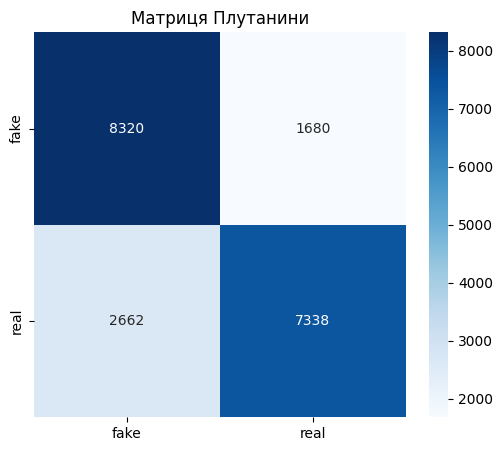

              precision    recall  f1-score   support

        fake       0.76      0.83      0.79     10000
        real       0.81      0.73      0.77     10000

    accuracy                           0.78     20000
   macro avg       0.79      0.78      0.78     20000
weighted avg       0.79      0.78      0.78     20000

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3cb7b2b9463e4febf8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2202, in process_api
    data = await self.postprocess_data(block_fn, result["prediction"], state)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1924, in postprocess_data
    self.validate_outputs(block_fn, predictions)  # type: ignore
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1879, in validate_outputs
    rai

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3cb7b2b9463e4febf8.gradio.live
